# Viewing DICOM CT Scans With Correct Windowing

Computed Tomography (CT) scans correspond to the [Hounsfield Units](https://en.wikipedia.org/wiki/Hounsfield_scale) (HU), a quantitative scale for describing radiodensity.
However, the values stored in the CT DICOMs are not in Hounsfield Units, but are instead scaled. A linear transformation needs to be applied, which we can deduce from the DICOM meta information.

After this linear transformation of the pixel values to HU, we apply a windowing. Typical windowing values for a head CT are a center of 40 and a width of 80, however this can also be extracted from the DICOM headers.

In [18]:
%matplotlib inline

In [19]:
import os
import pydicom
import pandas as pd
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
from tqdm import tqdm

In [20]:
# check the input files
print(os.listdir("./data/rsna-intracranial-hemorrhage-detection"))

# reading all dcm files into train and text
train = sorted(glob("./data/rsna-intracranial-hemorrhage-detection/stage_2_train/*.dcm"))
test = sorted(glob("./data/rsna-intracranial-hemorrhage-detection/stage_2_test/*.dcm"))
print("len(train): ", len(train))
print("len(test): ", len(test))

['stage_2_sample_submission.csv', '.ipynb_checkpoints', 'stage_2_train.csv', 'stage_2_test', 'stage_2_train_flattened.csv', 'stage_2_train']
len(train):  752803
len(test):  121232


In [21]:
# load the csv containing the mapping of DICOM to classification labels
pd.reset_option('max_colwidth')
train_df = pd.read_csv("./data/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
print(train_df[:10])

                              ID  Label
0          ID_12cadc6af_epidural      0
1  ID_12cadc6af_intraparenchymal      0
2  ID_12cadc6af_intraventricular      0
3      ID_12cadc6af_subarachnoid      0
4          ID_12cadc6af_subdural      0
5               ID_12cadc6af_any      0
6          ID_38fd7baa0_epidural      0
7  ID_38fd7baa0_intraparenchymal      0
8  ID_38fd7baa0_intraventricular      0
9      ID_38fd7baa0_subarachnoid      0


In [22]:
train_df_epidural = train_df[
    (train_df["ID"].str.endswith("_epidural")) & (train_df["Label"] != 0)]
train_df_intraparenchymal = train_df[
    (train_df["ID"].str.endswith("_intraparenchymal")) & (train_df["Label"] != 0)]
train_df_intraventricular = train_df[
    (train_df["ID"].str.endswith("_intraventricular")) & (train_df["Label"] != 0)]
train_df_subarachnoid = train_df[
    (train_df["ID"].str.endswith("_subarachnoid")) & (train_df["Label"] != 0)]
train_df_subdural = train_df[
    (train_df["ID"].str.endswith("_subdural")) & (train_df["Label"] != 0)]
train_df_healthy = train_df[
    (train_df["ID"].str.endswith("_any")) & (train_df["Label"] != 1)]

print("len(train_df_epidural):", len(train_df_epidural))
print("len(train_df_intraparenchymal):", len(train_df_intraparenchymal))
print("len(train_df_intraventricular):", len(train_df_intraventricular))
print("len(train_df_subarachnoid):", len(train_df_subarachnoid))
print("len(train_df_subdural):", len(train_df_subdural))
# print("len(train_df_healthy):", len(train_df_healthy))

total_labeled = (
    len(train_df_epidural) + len(train_df_intraparenchymal) +\
    len(train_df_intraventricular) + len(train_df_subarachnoid) +\
    len(train_df_subdural) + len(train_df_healthy)
)

# Certain images have multiple hemorrhage labels assigned to the scan, not 1 class
print("len(total_labeled)", total_labeled)

train_df_unhealthy = train_df[
    (train_df["ID"].str.endswith("_any")) & (train_df["Label"] != 0)]
print("len(train_df_healthy):", len(train_df) - len(train_df_unhealthy))

len(train_df_epidural): 3145
len(train_df_intraparenchymal): 36118
len(train_df_intraventricular): 26205
len(train_df_subarachnoid): 35675
len(train_df_subdural): 47166
len(total_labeled) 793183
len(train_df_healthy): 4408909


## Flatten and Construct Dataframe for PyTorch Dataloader

Instead of using the provided `stage_2_train.csv`, we will be flattening the data and using `stage_2_train_flattened.csv`.

In [23]:
# Construct a new dataframe where the columns are [ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any]
labels = ["ID", "epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural", "any"]
flattened_df_dict = {label: [] for label in labels}

with tqdm(train_df.itertuples(index=False), total=len(train_df)) as t:
    for row in t:
        prefix, sop_uuid, label = row.ID.split("_")
        dcm_id = "_".join([prefix, sop_uuid])
        flattened_df_dict["ID"].append(dcm_id)
        flattened_df_dict[label].append(row.Label)
        for rest in labels:
            if rest not in ["ID", label]:
                flattened_df_dict[rest].append(0)

flattened_train_df = pd.DataFrame.from_dict(flattened_df_dict).groupby("ID").sum()

100%|██████████| 4516842/4516842 [00:11<00:00, 385256.37it/s]


In [24]:
flattened_train_df

,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
ID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_ffff82e46,0,0,0,0,0,0
ID_ffff922b9,0,0,1,0,0,1
ID_ffffb670a,0,0,0,1,0,1


In [25]:
flattened_train_df.to_csv("./data/rsna-intracranial-hemorrhage-detection/stage_2_train_flattened.csv")

In [26]:
aggregator = {}
with tqdm(flattened_train_df.itertuples(), total=len(flattened_train_df)) as t:
    for row in t:
        row_id = row[0]
        classes = sum(row[1:])
        if classes in aggregator:
            aggregator[classes].append(row_id)
        else:
            aggregator[classes] = [row_id,]

for k, v in aggregator.items():
    print("labels: {}".format(max(k - 1, 0)), len(v))

# print(aggregator[6])

100%|██████████| 752803/752803 [00:01<00:00, 628643.64it/s]


labels: 0 644870
labels: 1 75859
labels: 2 24826
labels: 3 6217
labels: 4 1008
labels: 5 23


## Visualize Random DICOM Image

Let's view a random DICOM image and see the importance of windowing and transformationto the Hounsfield Unit space.

In [27]:
# This block contains an older, less effective approach

def window_image(img, window_center, window_width, intercept, slope):
    img = (img*slope +intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(dcm):
    dicom_fields = [dcm[('0028','1050')].value, #window center
                    dcm[('0028','1051')].value, #window width
                    dcm[('0028','1052')].value, #intercept
                    dcm[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [28]:
# Trying out a new approach for bsb_windowing from the Kaggle Grandmaster preprocessing instructions
# 3 channel outputs correspond to brain, subdural, and soft tissue
def correct_dicom(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dicom(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window_image(dcm):
    # Following the conventions of https://radiopaedia.org/articles/ct-head-an-approach?lang=gb
    # https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing
    # https://www.kaggle.com/reppic/gradient-sigmoid-windowing

    brain_img = window_image(dcm, 40, 80) # brain matter; center 40, width 80
    subdural_img = window_image(dcm, 80, 200) # blood/subdural; center 50-100, width 130-300
    soft_img = window_image(dcm, 40, 380) # soft tissues; center 20-60, width 350-400
    # bone; center 600, width 2800
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

What does a sample pydicom file contain?

Train Case ID 14893
Image File Name: ID_051688a0d.dcm
epidural            0
intraparenchymal    0
intraventricular    0
subarachnoid        1
subdural            1
any                 1
Name: ID_051688a0d, dtype: int64
------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_051688a0d
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_b5d9e9e1'
(0020, 000d) Study Instance UID                  UI: ID_65adb6c01d
(0020, 000e) Series Instance UID                 UI: ID_5e5b435537
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000', '-113.458', '57.150']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.961262', '-0.275637']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows               

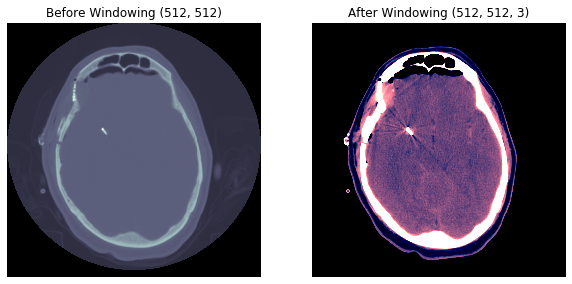

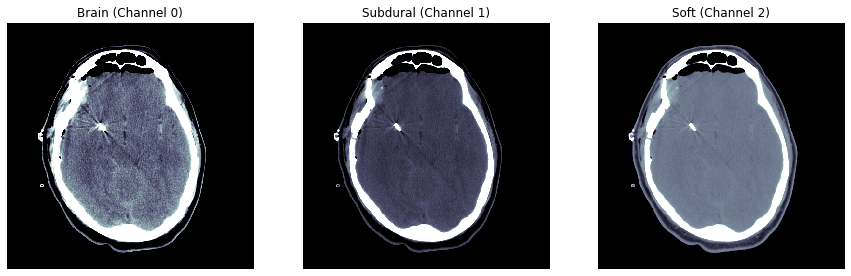

In [43]:
def sample_dicom(case):
    print("Train Case ID {}".format(case))
    file_name = os.path.basename(train[case])
    print("Image File Name: {}".format(file_name))
    dicom = pydicom.dcmread(train[case])

    labels = flattened_train_df.loc[os.path.splitext(file_name)[0]]
    print(labels)

    print("-" * 30)
    print(dicom)
    
    fig = plt.figure(figsize=(10, 20))

    # Before applying windowing
    img = dicom.pixel_array
    fig.add_subplot(1, 2, 1)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title("Before Windowing {}".format(img.shape))

    # After applying windowing
    # window_center , window_width, intercept, slope = get_windowing(dicom)
    # c_img = window_image(img, window_center, window_width, intercept, slope) # old approach
    c_img = bsb_window_image(dicom)
    fig.add_subplot(1, 2, 2)
    plt.imshow(c_img, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title("After Windowing {}".format(c_img.shape))

    plt.savefig("dicom_window.png", dpi=200)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    channel_types = ["Brain", "Subdural", "Soft"]
    for i in range(3):
        axs[i].set(title=channel_types[i] + " (Channel {})".format(i))
        axs[i].imshow(c_img[:,:,i], cmap=plt.cm.bone)
        axs[i].axis("off")

    plt.savefig("dicom_channels.png", dpi=200)

case = np.random.randint(0, len(train)) # random
# case = 272756  # ID_5c8b5d701: 3 subtype classification in image
# case = 113079  # ID_2669954a7: no ICH; clear break in skull, brain matter pouring out
# case = 243881  # ID_52c9913b1: no ICH; visualization of eyeballs and sinuses?
# case = 464735  # ID_9d9cc6b01: good subdural example
# case = 510381  # ID_ad3fadbc0: all 5 classifications in image
case = 14893  # ID_051688a0d: bullet in brain, subdural hemorrhage
# print(train.index("./data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_ad3fadbc0.dcm"))

sample_dicom(case)

## Visualizing Sample Images

Let's view various images with different diagnosis.

In [30]:
# print(dir(flattened_train_df.iloc[0]))
# flattened_train_df.iloc[0].name
# all(flattened_train_df.keys() == ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural", "any"])

def view_images(sop_instance_ids,
                title="",
                width=5,
                height=2,
                figsize=(15,5),
                train_image_dcm_path="./data/rsna-intracranial-hemorrhage-detection/stage_2_train/"):
    fig, axs = plt.subplots(height, width, figsize=figsize)

    for idx, sop_instance_id in enumerate(sop_instance_ids):
        dcm_path = os.path.join(train_image_dcm_path, "{}.dcm".format(sop_instance_id))
        dicom = pydicom.dcmread(dcm_path)

        c_img = bsb_window_image(dicom)
        i = idx // width
        j = idx % width
        axs[i,j].set(title=sop_instance_id)
        axs[i,j].imshow(c_img, cmap=plt.cm.bone)
        axs[i,j].axis("off")
        plt.imshow(c_img, cmap=plt.cm.bone)
    if title:
        plt.suptitle(title)
    plt.show()


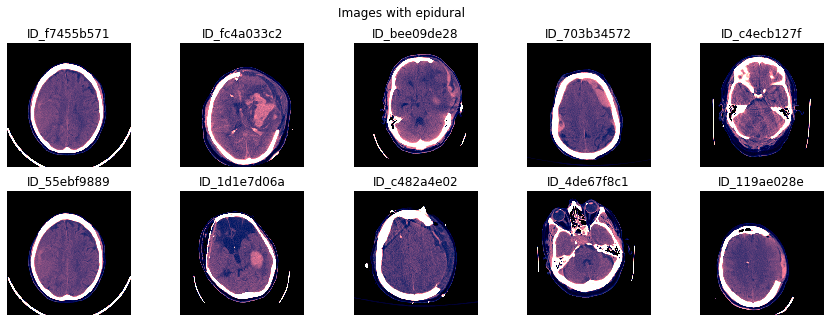

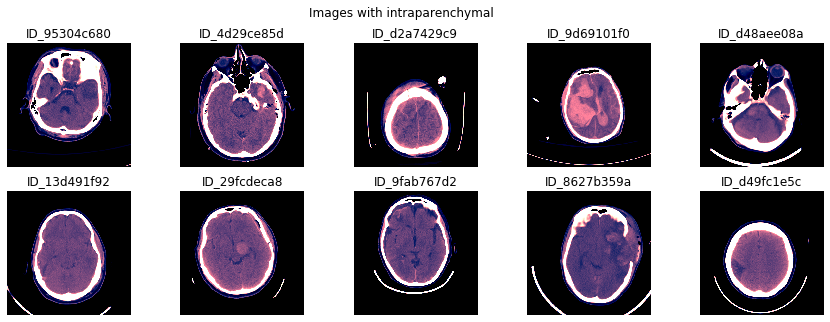

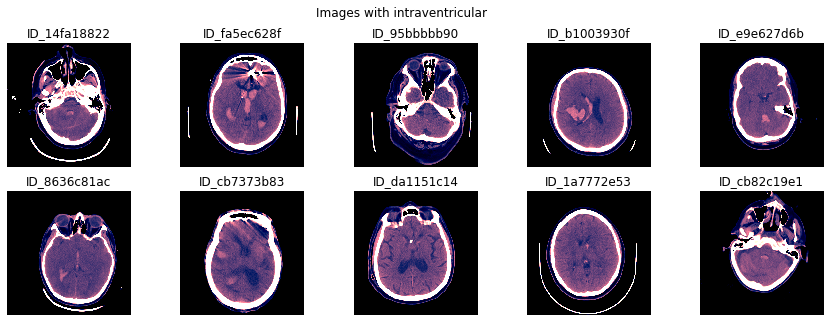

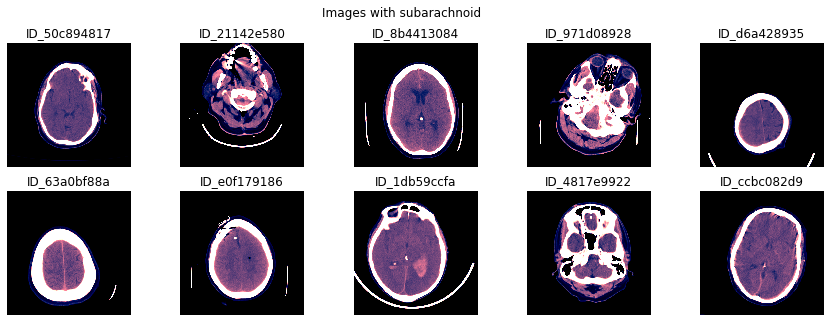

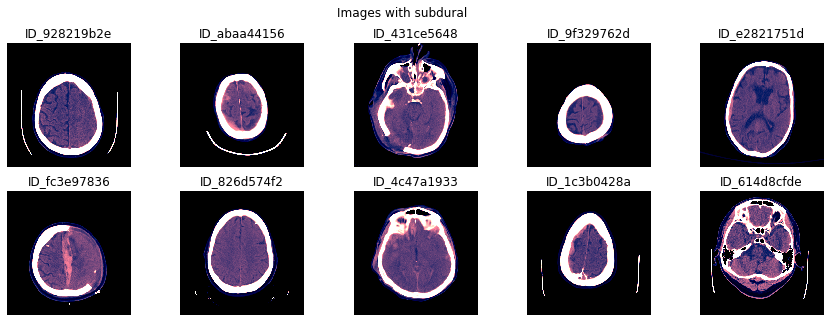

In [31]:
subtypes = ("epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural")

for subtype in subtypes:
    view_images(flattened_train_df[flattened_train_df[subtype] == 1]\
        .sample(10).index.values.tolist(), title="Images with {}".format(subtype))

## Normalization for windowed bsb images

Calculate the mean and standard deviation across the entire training dataset for the three windowed channels.

In [32]:
from multiprocessing import Pool
from tqdm import tqdm_notebook

def sum_sqsum_count(inp_file):
    c_iter = {}
    try:
        dcm = pydicom.dcmread(inp_file)
        img = bsb_window_image(dcm)
        for channel in range(3):
            c_sum, c_sqsum, c_count = c_iter.get(channel, (0.0, 0.0, 0.0))
            c_sum += img[:,:,channel].sum()
            c_sqsum += (img[:,:,channel] ** 2).sum()
            c_count += img[:,:,channel].size
            c_iter[channel] = (c_sum, c_sqsum, c_count)
    except:
        pass
    return c_iter

if False:
    with Pool() as p:
        c_iter = {}
        for idx, inv_c_iter in enumerate(p.imap_unordered(sum_sqsum_count, train)):
            for channel, v in inv_c_iter.items():
                c_cum = c_iter.get(channel, (0.0, 0.0, 0.0))
                c_iter[channel] = tuple(map(sum, zip(c_cum, v)))
            if idx % 25000 == 0:
                print("{}/{}".format(idx, len(train), end="\r"))

# for inp_file in tqdm(train):
#     dcm = pydicom.dcmread(inp_file)
#     img = bsb_window_image(dcm)
#     for channel in range(3):
#         c_sum, c_sqsum, c_count = c_iter.get(channel, (0.0, 0.0, 0.0))
#         c_sum += img[:,:,channel].sum()
#         c_sqsum += (img[:,:,channel] ** 2).sum()
#         c_count += img[:,:,channel].size
#         c_iter[channel] = (c_sum, c_sqsum, c_count)

In [33]:
if False:
    ds_means = []
    ds_stds = []

    for channel in range(3):
        c_sum, c_sqsum, c_count = c_iter.get(channel, (0, 0, 0))
        mean = c_sum / c_count
        std = ((c_sqsum / c_count) - (mean * mean)) ** 0.5
        ds_means.append(mean)
        ds_stds.append(std)
    print("mean:", ds_means)
    print("std:", ds_stds)
    # mean: [0.16195769124954246, 0.1331969086500524, 0.18349846540254727]
    # std: [0.3143255796442093, 0.2815477798845351, 0.3064693763439408]
